In [125]:
import numpy as np
import pandas as pd
import sklearn.compose as Compose

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb

Descargamos las datasets 

In [126]:
train_url = "https://raw.githubusercontent.com/w-dan/ML-practica1/main/train.csv"
df_train = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/w-dan/ML-practica1/main/test.csv"
df_test = pd.read_csv(test_url)

#df_test.Memory.unique()                       # Con esto vemos todos los valores posibles que tiene una columna

## Pre-procesamiento de datos de df_train

Vamos a guardar Price en la variable "y" y la vamos a separar del resto de columnas. 
También vamos a eliminar la columna "LaptopId" porque no nos aporta nada. 

In [127]:
index = df_train['LaptopId']
df_train = df_train.drop('LaptopId', axis=1)       # Borramos la ID porque no aporta nada

y = df_train['Price']
#df_train  

Como existen varios portátiles que disponen de dos tipos de memoria vamos a separar la columna "Memory" para distinguir entre estos tipos y su capacidad.
Lo distinguiremos en Memory1 y Memory2, cada una de ellas estará separada en su capacidad ("MemoryX_storage) y tipo ("MemoryX_type")

La tercera columna no nos aporta nada así que la borramos

###Tratamiento "Memory"

In [128]:
for index, row in df_train.iterrows():
   df_train.loc[index, 'Memory'].replace('Storage', '')

memory = df_train["Memory"].str.split(expand = True)
memory.columns = ['Memory1_storage', 'Memory1_type','borrar' ,'Memory2_storage', 'Memory2_type']

memory =  memory.drop('borrar', axis=1)       # borramos la tercera columna que no nos aporta nada.
memory

,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,128GB,SSD,None,None
1,256GB,SSD,None,None
2,128GB,SSD,1TB,HDD
3,256GB,SSD,None,None
4,256GB,SSD,None,None
...,...,...,...,...
907,256GB,SSD,None,None
908,128GB,SSD,1TB,HDD
909,2TB,HDD,None,None
910,1TB,HDD,None,None


Ahora vamos a eliminar la columna de "Memory" original que ya teníamos y vamos
a concatenar la nueva tabla con la anterior

Ahora vamos a convertir los TB a GB, para ello tenemos que recorrer las filas y sustituir los valores. Como el compilador no nos deja recorrer los datos si tenemos valores "None" vamos a convertirlo temporalmente a String para poder hacer esto.

Después de convertir los distintos datos a GB, vamos a covertir los valores "None", ya sean String o None, a un 0.

Ahora ya tendremos todos los datos de capacidad den Gigabytes

In [129]:
# Modificamos la antigua columna de Memory por las que hemos creado

df_train = df_train.drop('Memory', axis=1) 
df_train = pd.concat([df_train, memory], axis = 1)

# Convertimos todos los None en ceros

df_train['Memory2_storage'].replace(to_replace = [None], value = "None", inplace = True)
df_train['Memory1_storage'].replace(to_replace = [None], value = "None", inplace = True)

# Convertimos TB a GB

for index, row in df_train.iterrows():
   if 'TB' in row['Memory2_storage']:
     gb = int(df_train.loc[index, 'Memory2_storage'][0])*1024 
     df_train.loc[index, 'Memory2_storage'] = f"{gb}GB"


for index, row in df_train.iterrows():
   if 'TB' in row['Memory1_storage']:
     gb = int(df_train.loc[index, 'Memory1_storage'][0])*1024
     df_train.loc[index, 'Memory1_storage'] = f"{gb}GB"


df_train['Memory2_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_train['Memory1_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_train['Memory2_type'].replace(to_replace = [None], value = "0", inplace = True)                  # El 0 lo pongo como String para que luego al convertir los datos lo haga bien
df_train['Memory1_type'].replace(to_replace = [None], value = "0", inplace = True)


df_train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,Intel HD Graphics 520,Windows 7,1.2kg,1195.00,128GB,SSD,0,0
1,HP,Spectre 13-V111dx,Ultrabook,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,Intel HD Graphics 620,Windows 10,1.11kg,1349.00,256GB,SSD,0,0
2,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,Intel UHD Graphics 620,Windows 10,2.02kg,855.00,128GB,SSD,1024GB,HDD
3,HP,Envy 13-ad009n,Ultrabook,13.3,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,Nvidia GeForce MX150,Windows 10,1.38kg,1119.00,256GB,SSD,0,0
4,Dell,Latitude 7280,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics,Windows 10,1.36kg,1472.20,256GB,SSD,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics 620,Windows 10,1.68kg,889.00,256GB,SSD,0,0
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,Nvidia GeForce GTX 1050,Windows 10,3kg,1168.00,128GB,SSD,1024GB,HDD
909,Dell,Inspiron 5567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,AMD Radeon R7 M445,Windows 10,2.32kg,989.99,2048GB,HDD,0,0
910,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,AMD Radeon R5 M430,Linux,2.2kg,599.90,1024GB,HDD,0,0


Ahora vamos a hacer como con la RAM, eliminar la subcadena "GB" de los discos. Para ello usamos el mismo método de antes, pero surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

###Normalizando

Vamos a convertir los valores de "Typename", "Company", "OpSys", etc... en números para que se pueda trabajar con ellos.

También vamos a eliminar "GB" de los elementos de la columna RAM y las memorias al igual que vamos a eliminar "kg" de la columna "Weight" para dejar sólo los números    

Con las memorias surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

Normalizamos las columnas que tenemos

In [130]:
df_train['Ram'] = df_train['Ram'].map(lambda x: str(x)[:-2])                                # Eliminamos dos últimos caracteres del contenido de 'Ram'
df_train['Weight'] = df_train['Weight'].map(lambda x: str(x)[:-2])                          # Igual con 'Weight'
df_train['Memory1_storage'] = df_train['Memory1_storage'].map(lambda x: str(x)[:-2])       
df_train['Memory2_storage'] = df_train['Memory2_storage'].map(lambda x: str(x)[:-2])

df_train = df_train.replace(r'^\s*$', value = 0, regex=True)                                #Cambia los espacios vacios por 0   ^\s*$ es espacio vacío

# Transformamos los valores del tipo de memoria para que sean tratables

enc = OrdinalEncoder()
df_train[['Memory1_type', 'Memory2_type', 'TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu']] = enc.fit_transform(df_train[['Memory1_type', 'Memory2_type', 'TypeName', 'Company', 'OpSys', 'Product', 'ScreenResolution', 'Cpu', 'Gpu']])

# Normalizamos todos los valores númericos que tenemos de momento
df_train[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']] = MinMaxScaler().fit_transform(df_train[['Company', 'TypeName', 'Inches', 'Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'OpSys', 'Weight', 'Cpu', 'Gpu', 'ScreenResolution', 'Product']])

df_train

Tratamiento de la columna CPU

Primero separamos las cadenas de caracteteres

In [131]:
prueba = df_train['Cpu'].str.split()

A continuación vamos a guardar en un array la parte que queremos separar

In [132]:
Cpu_Company = [x[0] for x in prueba]
Cpu_Model = [" ".join(x[1:-2]) for x in prueba]
Cpu_Frecuency = [x[-1] for x in prueba]

Después añadimos al Dataset las nuevas columnas que hemos creado

In [133]:
df_train['Cpu_Company'] = pd.DataFrame(Cpu_Company)
df_train['Cpu_Model'] = pd.DataFrame(Cpu_Model)
df_train['Cpu_Frecuency(GHz)'] = pd.DataFrame(Cpu_Frecuency)

Por último eliminamos las unidades de la columna de Cpu_Frecuency

In [134]:
df_train['Cpu_Frecuency(GHz)'] = df_train['Cpu_Frecuency(GHz)'].map(lambda x: str(x)[:-3])
df_train = df_train.drop('Cpu', axis=1)

Ahora vamos a tratar la columna de ScreenResolution separando la resolución de la tecnología que usan. Para ello vamos a seguir el mismo procedimiento que seguimos con la columna CPU

In [135]:
prueba = df_train['ScreenResolution'].str.split()
screen_resolution = [x[-1:] for x in prueba]
screen_tecnology = [" ".join(x[0:-1]) for x in prueba]
df_train['Screen_Resolution'] = pd.DataFrame(screen_resolution)
df_train['Screen_Technology'] = pd.DataFrame(screen_tecnology)
df_train = df_train.drop('ScreenResolution', axis=1)


prueba = df_train['Gpu'].str.split()
Gpu_Company = [x[0] for x in prueba]
Gpu_Model = [" ".join(x[1:]) for x in prueba]
df_train['Gpu_Company'] = pd.DataFrame(Gpu_Company)
df_train['Gpu_Model'] = pd.DataFrame(Gpu_Model)
df_train = df_train.drop('Gpu', axis=1)
df_train

,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type,Cpu_Company,Cpu_Model,Cpu_Frecuency(GHz),Screen_Resolution,Screen_Technology,Gpu_Company,Gpu_Model
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,4,Windows 7,1.2,1195.00,128,SSD,0,0,Intel,Core i5,2.3,1920x1080,Full HD,Intel,HD Graphics 520
1,HP,Spectre 13-V111dx,Ultrabook,13.3,8,Windows 10,1.11,1349.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD / Touchscreen,Intel,HD Graphics 620
2,Dell,Inspiron 5570,Notebook,15.6,8,Windows 10,2.02,855.00,128,SSD,1024,HDD,Intel,Core i7,1.8,1920x1080,Full HD,Intel,UHD Graphics 620
3,HP,Envy 13-ad009n,Ultrabook,13.3,8,Windows 10,1.38,1119.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD,Nvidia,GeForce MX150
4,Dell,Latitude 7280,Ultrabook,12.5,8,Windows 10,1.36,1472.20,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,8,Windows 10,1.68,889.00,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics 620
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,8,Windows 10,3,1168.00,128,SSD,1024,HDD,Intel,Core i7,2.8,1920x1080,Full HD,Nvidia,GeForce GTX 1050
909,Dell,Inspiron 5567,Notebook,15.6,16,Windows 10,2.32,989.99,2048,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R7 M445
910,Dell,Inspiron 3567,Notebook,15.6,8,Linux,2.2,599.90,1024,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R5 M430


In [136]:
df_train['Company'].unique()

df_train

,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type,Cpu_Company,Cpu_Model,Cpu_Frecuency(GHz),Screen_Resolution,Screen_Technology,Gpu_Company,Gpu_Model
0,Toshiba,Portege Z30-C-1CV,Notebook,13.3,4,Windows 7,1.2,1195.00,128,SSD,0,0,Intel,Core i5,2.3,1920x1080,Full HD,Intel,HD Graphics 520
1,HP,Spectre 13-V111dx,Ultrabook,13.3,8,Windows 10,1.11,1349.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD / Touchscreen,Intel,HD Graphics 620
2,Dell,Inspiron 5570,Notebook,15.6,8,Windows 10,2.02,855.00,128,SSD,1024,HDD,Intel,Core i7,1.8,1920x1080,Full HD,Intel,UHD Graphics 620
3,HP,Envy 13-ad009n,Ultrabook,13.3,8,Windows 10,1.38,1119.00,256,SSD,0,0,Intel,Core i7,2.7,1920x1080,IPS Panel Full HD,Nvidia,GeForce MX150
4,Dell,Latitude 7280,Ultrabook,12.5,8,Windows 10,1.36,1472.20,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,Dell,Inspiron 5378,2 in 1 Convertible,13.3,8,Windows 10,1.68,889.00,256,SSD,0,0,Intel,Core i5,2.5,1920x1080,Full HD / Touchscreen,Intel,HD Graphics 620
908,Asus,FX753VD-GC007T (i7-7700HQ/8GB/1TB,Gaming,17.3,8,Windows 10,3,1168.00,128,SSD,1024,HDD,Intel,Core i7,2.8,1920x1080,Full HD,Nvidia,GeForce GTX 1050
909,Dell,Inspiron 5567,Notebook,15.6,16,Windows 10,2.32,989.99,2048,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R7 M445
910,Dell,Inspiron 3567,Notebook,15.6,8,Linux,2.2,599.90,1024,HDD,0,0,Intel,Core i7,2.7,1920x1080,Full HD,AMD,Radeon R5 M430


Preprocesamiento

In [137]:
oe = OrdinalEncoder();
df_train[["Company", "Product", "TypeName", "OpSys", "Memory1_type", "Memory2_type", "Cpu_Company", "Cpu_Model", "Screen_Resolution", "Screen_Technology", "Gpu_Company", "Gpu_Model"]] = oe.fit_transform(df_train[["Company", "Product", "TypeName", "OpSys", "Memory1_type", "Memory2_type", "Cpu_Company", "Cpu_Model", "Screen_Resolution", "Screen_Technology", "Gpu_Company", "Gpu_Model"]])

min_max_esclaer = Compose.ColumnTransformer(transformers=[
    ("Company", MinMaxScaler(), [0]),
    #("Product", MinMaxScaler(), [1]),
    ("TypeName", MinMaxScaler(), [2]),
    ("Inches", MinMaxScaler(), [3]),
    ("Ram", MinMaxScaler(), [4]),
    ("OpSys", MinMaxScaler(), [5]),
    ("Weight", MinMaxScaler(), [6]),
    ("Memory1_storage", MinMaxScaler(), [7]),
    ("Memory1_type", MinMaxScaler(), [8]),
    ("Memory2_storage", MinMaxScaler(), [9]),
    ("Memory2_type", MinMaxScaler(), [10]),
    ("Cpu_Company", MinMaxScaler(), [11]),
    ("Cpu_Model", MinMaxScaler(), [12]),
    ("Cpu_Frecuency", MinMaxScaler(), [13]),
    ("Screen_Resolution", MinMaxScaler(), [14]),
    ("Screen_Technology", MinMaxScaler(), [15]),
    ("Gpu_Company", MinMaxScaler(), [16]),
    ("Gpu_Model", MinMaxScaler(), [17])
])


min_max_esclaer.fit_transform(df_train)

df_train


,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Price,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type,Cpu_Company,Cpu_Model,Cpu_Frecuency(GHz),Screen_Resolution,Screen_Technology,Gpu_Company,Gpu_Model
0,16.0,262.0,3.0,13.3,4,7.0,1.2,1195.00,128,3.0,0,0.0,1.0,12.0,2.3,3.0,3.0,2.0,41.0
1,7.0,326.0,4.0,13.3,8,5.0,1.11,1349.00,256,3.0,0,0.0,1.0,13.0,2.7,3.0,9.0,2.0,46.0
2,4.0,191.0,3.0,15.6,8,5.0,2.02,855.00,128,3.0,1024,1.0,1.0,13.0,1.8,3.0,3.0,2.0,89.0
3,7.0,95.0,4.0,13.3,8,5.0,1.38,1119.00,256,3.0,0,0.0,1.0,13.0,2.7,3.0,8.0,3.0,32.0
4,4.0,215.0,4.0,12.5,8,5.0,1.36,1472.20,256,3.0,0,0.0,1.0,12.0,2.5,3.0,4.0,2.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,4.0,187.0,0.0,13.3,8,5.0,1.68,889.00,256,3.0,0,0.0,1.0,12.0,2.5,3.0,4.0,2.0,46.0
908,2.0,103.0,1.0,17.3,8,5.0,3,1168.00,128,3.0,1024,1.0,1.0,13.0,2.8,3.0,3.0,3.0,10.0
909,4.0,189.0,3.0,15.6,16,5.0,2.32,989.99,2048,1.0,0,0.0,1.0,13.0,2.7,3.0,3.0,0.0,81.0
910,4.0,183.0,3.0,15.6,8,2.0,2.2,599.90,1024,1.0,0,0.0,1.0,13.0,2.7,3.0,3.0,0.0,77.0


In [138]:
#X = ordinal_encoder.fit_transform(df_train.to_numpy())

In [139]:
#df_train = min_max_esclaer.fit_transform(df_train)

## Pre-procesamiento de datos de df_test

In [140]:
df_test = df_test.drop('LaptopId', axis=1)       # Borramos la ID porque no aporta nada

df_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,HP,Envy x360,2 in 1 Convertible,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.42kg
1,Lenovo,ThinkPad X1,2 in 1 Convertible,14.0,IPS Panel Touchscreen 2560x1440,Intel Core i7 6500U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.27kg
2,Acer,Aspire F5-573G-510L,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,12GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 950M,Windows 10,2.4kg
3,Asus,FX502VM-DM105T (i7-6700HQ/8GB/1TB/GeForce,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,1TB HDD,Nvidia GeForce GTX 1060,Windows 10,2.2kg
4,HP,EliteBook 850,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.88kg
...,...,...,...,...,...,...,...,...,...,...,...
386,HP,Probook 470,Notebook,17.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.5kg
387,Dell,Inspiron 3552,Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,500GB HDD,Intel HD Graphics,Windows 10,2.20kg
388,Asus,ZenBook UX530UQ-PRO,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Nvidia GeForce 940MX,Windows 10,1.63kg
389,Dell,Inspiron 3576,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 520,Windows 10,2.13kg


###Tratamiento "Memory"

Como existen varios portátiles que disponen de dos tipos de memoria vamos a separar la columna "Memory" para distinguir entre estos tipos y su capacidad. Lo distinguiremos en Memory1 y Memory2, cada una de ellas estará separada en su capacidad ("MemoryX_storage) y tipo ("MemoryX_type")

La tercera columna no nos aporta nada así que la borramos

In [141]:
for index, row in df_test.iterrows():
  df_test.loc[index, 'Memory'] = df_test.loc[index, 'Memory'].replace("Storage", "")

memoryt = df_test["Memory"].str.split(expand = True)
memoryt.columns = ['Memory1_storage', 'Memory1_type','borrar' ,'Memory2_storage', 'Memory2_type']

memoryt =  memoryt.drop('borrar', axis=1)       # borramos la tercera columna que no nos aporta nada.
memoryt

,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,256GB,SSD,None,None
1,256GB,SSD,None,None
2,128GB,SSD,1TB,HDD
3,1TB,HDD,None,None
4,256GB,SSD,None,None
...,...,...,...,...
386,1TB,HDD,None,None
387,500GB,HDD,None,None
388,512GB,SSD,None,None
389,256GB,SSD,None,None


Ahora vamos a convertir los TB a GB, para ello tenemos que recorrer las filas y sustituir los valores. Como el compilador no nos deja recorrer los datos si tenemos valores "None" vamos a convertirlo temporalmente a String para poder hacer esto.

Después de convertir los distintos datos a GB, vamos a covertir los valores "None", ya sean String o None, a un 0.

Ahora ya tendremos todos los datos de capacidad den Gigabytes

In [142]:
df_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,HP,Envy x360,2 in 1 Convertible,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7500U 2.7GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.42kg
1,Lenovo,ThinkPad X1,2 in 1 Convertible,14.0,IPS Panel Touchscreen 2560x1440,Intel Core i7 6500U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.27kg
2,Acer,Aspire F5-573G-510L,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,12GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 950M,Windows 10,2.4kg
3,Asus,FX502VM-DM105T (i7-6700HQ/8GB/1TB/GeForce,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,1TB HDD,Nvidia GeForce GTX 1060,Windows 10,2.2kg
4,HP,EliteBook 850,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.88kg
...,...,...,...,...,...,...,...,...,...,...,...
386,HP,Probook 470,Notebook,17.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.5kg
387,Dell,Inspiron 3552,Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,500GB HDD,Intel HD Graphics,Windows 10,2.20kg
388,Asus,ZenBook UX530UQ-PRO,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Nvidia GeForce 940MX,Windows 10,1.63kg
389,Dell,Inspiron 3576,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 520,Windows 10,2.13kg


In [143]:
# Sustituimos la antigua columna de Memory por las creadas anteriormente

df_test = df_test.drop('Memory', axis=1) 
df_test = pd.concat([df_test, memoryt], axis = 1)
df_test

# Convertimos todos los None en ceros

df_test['Memory2_storage'].replace(to_replace = [None], value = "None", inplace = True)
df_test['Memory1_storage'].replace(to_replace = [None], value = "None", inplace = True)

# Convertimos de TB a GB

for index, row in df_test.iterrows():
   if 'TB' in row['Memory2_storage']:
     gb = int(df_test.loc[index, 'Memory2_storage'][0])*1024 
     df_test.loc[index, 'Memory2_storage'] = f"{gb}GB"


for index, row in df_test.iterrows():
   if 'TB' in row['Memory1_storage']:
     gb = int(df_test.loc[index, 'Memory1_storage'][0])*1024
     df_test.loc[index, 'Memory1_storage'] = f"{gb}GB"


df_test['Memory2_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_test['Memory1_storage'].replace(to_replace = ["None"], value = 0, inplace = True)
df_test['Memory2_type'].replace(to_replace = [None], value = "0", inplace = True)                  # El 0 lo pongo como String para que luego al convertir los datos lo haga bien
df_test['Memory1_type'].replace(to_replace = [None], value = "0", inplace = True)

df_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Gpu,OpSys,Weight,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type
0,HP,Envy x360,2 in 1 Convertible,13.3,Quad HD+ / Touchscreen 3200x1800,Intel Core i7 7500U 2.7GHz,16GB,Intel HD Graphics 620,Windows 10,1.42kg,256GB,SSD,0,0
1,Lenovo,ThinkPad X1,2 in 1 Convertible,14.0,IPS Panel Touchscreen 2560x1440,Intel Core i7 6500U 2.5GHz,8GB,Intel HD Graphics 520,Windows 10,1.27kg,256GB,SSD,0,0
2,Acer,Aspire F5-573G-510L,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,12GB,Nvidia GeForce GTX 950M,Windows 10,2.4kg,128GB,SSD,1024GB,HDD
3,Asus,FX502VM-DM105T (i7-6700HQ/8GB/1TB/GeForce,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,Nvidia GeForce GTX 1060,Windows 10,2.2kg,1024GB,HDD,0,0
4,HP,EliteBook 850,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 6500U 2.5GHz,8GB,Intel HD Graphics 520,Windows 7,1.88kg,256GB,SSD,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,HP,Probook 470,Notebook,17.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,Nvidia GeForce 930MX,Windows 10,2.5kg,1024GB,HDD,0,0
387,Dell,Inspiron 3552,Notebook,15.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,Intel HD Graphics,Windows 10,2.20kg,500GB,HDD,0,0
388,Asus,ZenBook UX530UQ-PRO,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,Nvidia GeForce 940MX,Windows 10,1.63kg,512GB,SSD,0,0
389,Dell,Inspiron 3576,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,AMD Radeon 520,Windows 10,2.13kg,256GB,SSD,0,0


Ahora vamos a hacer como con la RAM, eliminar la subcadena "GB" de los discos. Para ello usamos el mismo método de antes, pero 

###Normalizando

Vamos a convertir los valores de "Typename", "Company", "OpSys", etc... en números para que se pueda trabajar con ellos.

También vamos a eliminar "GB" de los elementos de la columna RAM y las memorias al igual que vamos a eliminar "kg" de la columna "Weight" para dejar sólo los números    

Con las memorias surge un problema, en los portátiles que no tienen alguno de sus discos se nos borra el valor 0.

Esto tiene fácil solución, usamos una función para que nos sustituya los valores vacíos por 0.

Normalizamos las columnas que tenemos

In [144]:
print(df_test.columns)

Index(['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu',
       'Ram', 'Gpu', 'OpSys', 'Weight', 'Memory1_storage', 'Memory1_type',
       'Memory2_storage', 'Memory2_type'],
      dtype='object')


In [145]:
# MEMORIA:
df_test['Ram'] = df_test['Ram'].map(lambda x: str(x)[:-2])                     # Eliminamos dos últimos caracteres del contenido de 'Ram'
df_test['Weight'] = df_test['Weight'].map(lambda x: str(x)[:-2])               # Igual con 'Weight'
df_test['Memory1_storage'] = df_test['Memory1_storage'].map(lambda x: str(x)[:-2])
df_test['Memory2_storage'] = df_test['Memory2_storage'].map(lambda x: str(x)[:-2])

df_test = df_test.replace(r'^\s*$', value = 0, regex=True)                       #Cambia los espacios vacios por 0   ^\s*$ es espacio vacío

# CPU:
# separamos los datos distintos de la CPU
prueba = df_test['Cpu'].str.split()

# aislamos los atributos company model y frequency
Cpu_Company = [x[0] for x in prueba]
Cpu_Model = [" ".join(x[1:-2]) for x in prueba]
Cpu_Frecuency = [x[-1] for x in prueba]

# obtenemos dataframes
df_test['Cpu_Company'] = pd.DataFrame(Cpu_Company)
df_test['Cpu_Model'] = pd.DataFrame(Cpu_Model)
df_test['Cpu_Frecuency(GHz)'] = pd.DataFrame(Cpu_Frecuency)

# separamos los campos para la frecuencia de la CPU
df_test['Cpu_Frecuency(GHz)'] = df_test['Cpu_Frecuency(GHz)'].map(lambda x: str(x)[:-3])
df_test = df_test.drop('Cpu', axis=1)

# RESOLUCION:
# separamos los campos para la resolucion
prueba = df_test['ScreenResolution'].str.split()
screen_resolution = [x[-1:] for x in prueba]
screen_tecnology = [" ".join(x[0:-1]) for x in prueba]
df_test['Screen_Resolution'] = pd.DataFrame(screen_resolution)
df_test['Screen_Technology'] = pd.DataFrame(screen_tecnology)
df_test = df_test.drop('ScreenResolution', axis=1)

# GPU:
# separamos los campos de la GPU
prueba = df_test['Gpu'].str.split()
Gpu_Company = [x[0] for x in prueba]
Gpu_Model = [" ".join(x[1:]) for x in prueba]
df_test['Gpu_Company'] = pd.DataFrame(Gpu_Company)
df_test['Gpu_Model'] = pd.DataFrame(Gpu_Model)
df_test = df_test.drop('Gpu', axis=1)

# TRATAMIENTO DE VALORES DISCRETOS
df_test[["Company", "Product", "TypeName", "OpSys", "Memory1_type", "Memory2_type", "Cpu_Company", "Cpu_Model", "Screen_Resolution", "Screen_Technology", "Gpu_Company", "Gpu_Model"]] = oe.fit_transform(df_test[["Company", "Product", "TypeName", "OpSys", "Memory1_type", "Memory2_type", "Cpu_Company", "Cpu_Model", "Screen_Resolution", "Screen_Technology", "Gpu_Company", "Gpu_Model"]])


min_max_esclaer = Compose.ColumnTransformer(transformers=[
    ("Company", MinMaxScaler(), [0]),
    #("Product", MinMaxScaler(), [1]),
    ("TypeName", MinMaxScaler(), [2]),
    ("Inches", MinMaxScaler(), [3]),
    ("Ram", MinMaxScaler(), [4]),
    ("OpSys", MinMaxScaler(), [5]),
    ("Weight", MinMaxScaler(), [6]),
    ("Memory1_storage", MinMaxScaler(), [7]),
    ("Memory1_type", MinMaxScaler(), [8]),
    ("Memory2_storage", MinMaxScaler(), [9]),
    ("Memory2_type", MinMaxScaler(), [10]),
    ("Cpu_Company", MinMaxScaler(), [11]),
    ("Cpu_Model", MinMaxScaler(), [12]),
    ("Cpu_Frecuency", MinMaxScaler(), [13]),
    ("Screen_Resolution", MinMaxScaler(), [14]),
    ("Screen_Technology", MinMaxScaler(), [15]),
    ("Gpu_Company", MinMaxScaler(), [16]),
    ("Gpu_Model", MinMaxScaler(), [17])
])


min_max_esclaer.fit_transform(df_test)


df_test

,Company,Product,TypeName,Inches,Ram,OpSys,Weight,Memory1_storage,Memory1_type,Memory2_storage,Memory2_type,Cpu_Company,Cpu_Model,Cpu_Frecuency(GHz),Screen_Resolution,Screen_Technology,Gpu_Company,Gpu_Model
0,5.0,52.0,0.0,13.3,16,4.0,1.42,256,3.0,0,0.0,1.0,12.0,2.7,10.0,16.0,1.0,35.0
1,6.0,194.0,0.0,14.0,8,4.0,1.27,256,3.0,0,0.0,1.0,12.0,2.5,6.0,13.0,1.0,30.0
2,0.0,30.0,3.0,15.6,12,4.0,2.4,128,3.0,1024,1.0,1.0,11.0,2.5,3.0,3.0,2.0,15.0
3,2.0,55.0,1.0,15.6,8,4.0,2.2,1024,1.0,0,0.0,1.0,12.0,2.6,3.0,3.0,2.0,12.0
4,5.0,46.0,4.0,15.6,8,5.0,1.88,256,3.0,0,0.0,1.0,12.0,2.5,3.0,3.0,1.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,5.0,162.0,3.0,17.3,8,4.0,2.5,1024,1.0,0,0.0,1.0,12.0,1.8,3.0,3.0,2.0,7.0
387,4.0,95.0,3.0,15.6,2,4.0,2.20,500,1.0,0,0.0,1.0,6.0,1.6,0.0,0.0,1.0,23.0
388,2.0,255.0,4.0,15.6,16,4.0,1.63,512,3.0,0,0.0,1.0,12.0,2.7,3.0,3.0,2.0,8.0
389,4.0,97.0,3.0,15.6,8,4.0,2.13,256,3.0,0,0.0,1.0,11.0,1.6,3.0,3.0,0.0,46.0


##XGBOOST

In [146]:
print(df_test.columns)

Index(['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight',
       'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type',
       'Cpu_Company', 'Cpu_Model', 'Cpu_Frecuency(GHz)', 'Screen_Resolution',
       'Screen_Technology', 'Gpu_Company', 'Gpu_Model'],
      dtype='object')


In [147]:
df_train.dtypes

Company               float64
Product               float64
TypeName              float64
Inches                float64
Ram                    object
OpSys                 float64
Weight                 object
Price                 float64
Memory1_storage        object
Memory1_type          float64
Memory2_storage        object
Memory2_type          float64
Cpu_Company           float64
Cpu_Model             float64
Cpu_Frecuency(GHz)     object
Screen_Resolution     float64
Screen_Technology     float64
Gpu_Company           float64
Gpu_Model             float64
dtype: object

In [148]:
df_test.dtypes

Company               float64
Product               float64
TypeName              float64
Inches                float64
Ram                    object
OpSys                 float64
Weight                 object
Memory1_storage        object
Memory1_type          float64
Memory2_storage        object
Memory2_type          float64
Cpu_Company           float64
Cpu_Model             float64
Cpu_Frecuency(GHz)     object
Screen_Resolution     float64
Screen_Technology     float64
Gpu_Company           float64
Gpu_Model             float64
dtype: object

Como se puede apreciar, las columnas Cpu_Frequency(GHz), Ram, Weight, Memory1_storage, y Memory2_storage se reconocen como tipo 'object' tras su preprocesamiento, por lo que hay que convertirlos a tipo float para que el regresor pueda funcionar. 

In [149]:
# columna Ram
df_train['Ram'] = df_train['Ram'].astype(float)
df_test['Ram'] = df_test['Ram'].astype(float)

# columna Weight
df_train['Weight'] = df_train['Weight'].astype(float)
df_test['Weight'] = df_test['Weight'].astype(float)

# columna Memory1_storage
df_train['Memory1_storage'] = df_train['Memory1_storage'].astype(float)
df_test['Memory1_storage'] = df_test['Memory1_storage'].astype(float)

# columna Memory2_storage
df_train['Memory2_storage'] = df_train['Memory2_storage'].astype(float)
df_test['Memory2_storage'] = df_test['Memory2_storage'].astype(float)

# columna Cpu_Frecuency(GHz)
df_train['Cpu_Frecuency(GHz)'] = df_train['Cpu_Frecuency(GHz)'].astype(float)
df_test['Cpu_Frecuency(GHz)'] = df_test['Cpu_Frecuency(GHz)'].astype(float)


X_train = df_train[['Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Company', 'OpSys', 'Weight', 'Product', 'Inches', 'TypeName']]
X_test  =  df_test[['Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Company', 'OpSys', 'Weight', 'Product', 'Inches', 'TypeName']]

In [150]:
df_test.dtypes

Company               float64
Product               float64
TypeName              float64
Inches                float64
Ram                   float64
OpSys                 float64
Weight                float64
Memory1_storage       float64
Memory1_type          float64
Memory2_storage       float64
Memory2_type          float64
Cpu_Company           float64
Cpu_Model             float64
Cpu_Frecuency(GHz)    float64
Screen_Resolution     float64
Screen_Technology     float64
Gpu_Company           float64
Gpu_Model             float64
dtype: object

In [151]:
df_train.dtypes

Company               float64
Product               float64
TypeName              float64
Inches                float64
Ram                   float64
OpSys                 float64
Weight                float64
Price                 float64
Memory1_storage       float64
Memory1_type          float64
Memory2_storage       float64
Memory2_type          float64
Cpu_Company           float64
Cpu_Model             float64
Cpu_Frecuency(GHz)    float64
Screen_Resolution     float64
Screen_Technology     float64
Gpu_Company           float64
Gpu_Model             float64
dtype: object

Efectivamente, ahora todos son float64.

[10:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


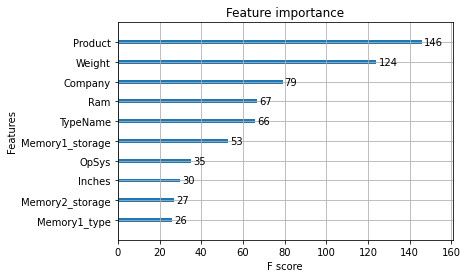

In [152]:
X = df_train[['Ram', 'Memory1_storage', 'Memory1_type', 'Memory2_storage', 'Memory2_type', 'Company', 'OpSys', 'Weight', 'Product', 'Inches', 'TypeName']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBRegressor()

# Fitting the model
model.fit(X_train, y_train)

# Pintamos la importancia de cada una de las columnas

%matplotlib inline
xgb.plot_importance(model, ax=plt.gca())

In [153]:
predTrain = model.predict(X_train)        # Predicción del Train
pred = model.predict(X_test)              # Predicción del Test

print("MAE (train): ", mean_absolute_error(y_train, predTrain))
print("MAE (test): ", mean_absolute_error(y_test, pred))

MAE (train):  155.63395443333354
MAE (test):  215.09256983624758


In [154]:
pred

array([1983.8787 , 1546.1455 , 1465.593  , 1766.7891 , 1663.6615 ,
       2723.6794 , 1199.7158 , 1045.6466 ,  724.9451 ,  360.52762,
       1123.1187 , 2409.7507 , 1389.09   ,  607.21796, 1546.1455 ,
        339.224  , 1309.8751 ,  728.11127,  679.7045 ,  883.9355 ,
       1072.6888 ,  598.6467 , 1137.0767 , 1262.2443 , 1080.3162 ,
       1207.945  , 1096.8992 , 1070.5687 , 1039.0626 , 1895.8085 ,
        888.386  , 1065.9354 ,  403.09146,  913.4919 ,  549.0848 ,
        599.75104,  619.7501 , 1298.6738 , 2366.1968 ,  778.83014,
       2274.7878 ,  539.3843 , 1341.3037 , 1467.8555 ,  562.7084 ,
       3011.1763 , 1869.3846 ,  748.7574 ,  639.2758 ,  443.89346,
        438.09756,  428.27533, 1219.6716 ,  857.25903, 1096.9316 ,
       1262.801  ,  979.7045 , 1174.5184 , 1058.4238 ,  438.09756,
       2424.7788 ,  619.7501 ,  737.6289 , 1189.135  , 1129.8822 ,
        446.6591 , 1233.98   , 1656.8373 ,  413.93146, 1009.2204 ,
       2672.5955 ,  358.83084, 1123.1187 , 1068.8745 ,  340.54

##Otras cosas:

### Dudas:

- ¿Se puede usar XGBoost para esta práctica?

### Cosas que hacer (Cynthia):

- Hacer lo de las Seed y eso para XGBoost


### Bibliografía

Sitios de los que he sacado infomación y otros que pueden venir bien luego



split:

https://www.analyticslane.com/2020/10/19/separar-texto-en-columnas-con-pandas-en-python/


iterar elementos del Dataframe:

https://www.analyticslane.com/2021/09/13/pandas-como-iterar-sobre-las-filas-de-un-dataframe-en-pandas/


pandas:

https://guias.makeitreal.camp/pandas/inspeccion-y-seleccion-de-datos


eliminar duplicados (Aquí no hay):

https://cursosinformatica.ucm.es/trial/analisis/